# M5 Forecasting Challenge: LightGBM Model
#### Author: Stacy Liu

## Introduction

**LightGBM Model**:Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.

It is designed to be distributed and efficient with the following advantages: (1) Faster training speed and higher efficiency, (2) Lower memory usage, (3) Better accuracy, (4) Support of parallel and GPU learning, (5) Capable of handling large-scale data (https://lightgbm.readthedocs.io/en/latest/)


**The goal of LightGBM Notebook**: This notebook will be used to predict sales using LightGBM

**The data**: We are working with **42,840 hierarchical time series**. The data were obtained in the 3 US states of California (CA), Texas (TX), and Wisconsin (WI). “Hierarchical” here means that data can be aggregated on different levels: item level, department level, product category level, and state level. The sales information reaches back from Jan 2011 to June 2016. In addition to the sales numbers, we are also given corresponding data on prices, promotions, and holidays. Note, that we have been warned that **most of the time series contain zero values.**

The data comprises **3049** individual products from *3 categories* and *7 departments*, sold in 10 stores in 3 states. The hierachical aggregation captures the combinations of these factors. For instance, we can create 1 time series for all sales, 3 time series for all sales per state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

The training data comes in the shape of 4 separate files:

- sales_train.csv: this is our main training data.  Contains the historical daily unit sales data per product and store from d_1 - d_1913.

- sell_prices.csv: the store and item IDs together with the sales price of the item as a weekly average.

- calendar.csv: dates together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).

- sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales from d_1 - d_1941.

**The metrics:**

The point forecast submission are being evaluated using the **Root Mean Squared Scaled Error (RMSSE)**, which is derived from the Mean Absolute Scaled Error (MASE) that was designed to be scale invariant and symmetric. 

**Model & Results:**
- Additional features added: (1) lagging 7, 28 day demand, (2) rolling 7, 28 day mean demand, (3) additional date features
- parameters used = {
          "objective" : "poisson",
          "metric" :"rmse",
          "force_row_wise" : True,
          "learning_rate" : 0.075,
          "sub_row" : 0.75,
          "bagging_freq" : 1,
          "lambda_l2" : 0.1,
          "metric": ["rmse"],
          'verbosity': 1,
          'num_iterations' : 1200,
          'num_leaves': 128,
          "min_data_in_leaf": 100,
         }
- Result: **2.93753** on the test set


## Initial Data Loading

In [4]:
# Import libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle
import os
import lightgbm as lgb
from sklearn import preprocessing, metrics
import gc

%matplotlib inline

Run the below code to reduce memory usage when importing cvs

In [5]:
def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if   c_min > np.iinfo(np.int8 ).min and c_max < np.iinfo(np.int8).max :
                    df[col] = df[col].astype(np.int8 )
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if   c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        
    return df

Read in sell prices data

In [6]:
# Correct data types for "sell_prices.csv"
priceDTypes = {"store_id": "category", 
               "item_id": "category", 
               "wm_yr_wk": "int16",
               "sell_price":"float32"}

#sub_filename = r"Data\m5-forecasting-accuracy-updated\sell_prices.csv"
sub_filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sell_prices.csv")
prices = reduce_mem_usage(pd.read_csv(sub_filename, dtype = priceDTypes))

# Transform categorical features into integers
for col, colDType in priceDTypes.items():
    if colDType == "category":
        prices[col] = prices[col].cat.codes.astype("int16")
        prices[col] -= prices[col].min()
        
prices.head()

Mem. usage decreased to 45.77 Mb (22.2% reduction)


,store_id,item_id,wm_yr_wk,sell_price
0,0,0,11325,9.578125
1,0,0,11326,9.578125
2,0,0,11327,8.257812
3,0,0,11328,8.257812
4,0,0,11329,8.257812


In [7]:
#sub_filename = r"C:\Users\19173\Desktop\Kaggle\M5 Forecasting Accuracy\Data\m5-forecasting-accuracy-updated\sample_submission.csv"
sub_filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sample_submission.csv")
submission = reduce_mem_usage(pd.read_csv(sub_filename))

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [8]:
# Correct data types for "calendar.csv"
calendarDTypes = {"event_name_1": "category", 
                  "event_name_2": "category", 
                  "event_type_1": "category", 
                  "event_type_2": "category", 
                  "weekday": "category", 
                  'wm_yr_wk': 'int16', 
                  "wday": "int16",
                  "month": "int16", 
                  "year": "int16", 
                  "snap_CA": "float32", 
                  'snap_TX': 'float32', 
                  'snap_WI': 'float32' }

#filename = r"C:\Users\19173\Desktop\Kaggle\M5 Forecasting Accuracy\Data\m5-forecasting-accuracy-updated\calendar.csv"
filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "calendar.csv")
calendar = reduce_mem_usage(pd.read_csv(filename, dtype = calendarDTypes))

calendar["date"] = pd.to_datetime(calendar["date"])

# Transform categorical features into integers
for col, colDType in calendarDTypes.items():
    if colDType == "category":
        calendar[col] = calendar[col].cat.codes.astype("int16")
        calendar[col] -= calendar[col].min()
        
calendar.tail()

Mem. usage decreased to  0.06 Mb (18.9% reduction)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0.0,1.0,1.0
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0.0,0.0,0.0
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0.0,0.0,0.0
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0.0,0.0,0.0
1968,2016-06-19,11621,3,2,6,2016,d_1969,17,4,3,1,0.0,0.0,0.0


In [9]:
firstDay = 250
lastDay = 1913

# Use x sales days (columns) for training
numCols = [f"d_{day}" for day in range(firstDay, lastDay+1)]

# Define all categorical columns
catCols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']

# Define the correct data types for "sales_train_evaluation.csv"
dtype = {numCol: "float32" for numCol in numCols} 
dtype.update({catCol: "category" for catCol in catCols if catCol != "id"})

#filename = r"C:\Users\19173\Desktop\Kaggle\M5 Forecasting Accuracy\Data\m5-forecasting-accuracy-updated\sales_train_evaluation.csv"
filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sales_train_evaluation.csv")
sales_train_evaluation = reduce_mem_usage(pd.read_csv(filename, usecols = catCols + numCols, dtype = dtype))

# Transform categorical features into integers
for col in catCols:
    if col != "id":
        sales_train_evaluation[col] = sales_train_evaluation[col].cat.codes.astype("int16")
        sales_train_evaluation[col] -= sales_train_evaluation[col].min()
   
sales_train_evaluation = pd.melt(sales_train_evaluation,
             id_vars = catCols,
             value_vars = [col for col in sales_train_evaluation.columns if col.startswith("d_")],
             var_name = "d",
             value_name = "sales")

Mem. usage decreased to 97.28 Mb (49.9% reduction)


In [10]:
# Prepare submission file
test1 = submission[submission['id'].str.contains('validation')] #first 28 days
test2 = submission[submission['id'].str.contains('evaluation')] #second 28 days
    
test1.columns = ['id'] + ['d_' + str(i) for i in range(1914, 1942)]
test2.columns = ['id'] + ['d_' + str(i) for i in range(1942, 1970)]

product = sales_train_evaluation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

test1['id'] =test1['id'].str.replace('validation', 'evaluation')
test1 = test1.merge(product, on = 'id', how = 'left')
#test1['id'] = test1['id'].str.replace('_evaluation', '_validation')
test2 = test2.merge(product, on = 'id', how = 'left')

# Wide to long dataset
test1 = pd.melt(test1,
                id_vars = catCols,
                #value_vars = [col for col in test1.columns if col.startswith("d_")],
                var_name = "d",
                value_name = "sales")
test2 = pd.melt(test2,
             id_vars = catCols,
             #value_vars = [col for col in test2.columns if col.startswith("d_")],
             var_name = "d",
             value_name = "sales")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
sales_train_evaluation['part'] = 'train'
test1['part'] = 'test1'
test2['part'] = 'test2'
sales = pd.concat([sales_train_evaluation, test1, test2], axis = 0)
sales = sales[sales['part'] != 'test2'] #delete the second 28 days until the model is ready for submission

Merge sales_train_evaluation with calendar and prices

In [12]:
sales = sales.merge(calendar, on = "d", copy = False)
sales = sales.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], how = 'left')

### Create additional features

**Sales features - create lagging 7, 28 and rolling 7, 28 day mean**

In [13]:
dayLags = [7, 28]
lagSalesCols = [f"lag_{dayLag}" for dayLag in dayLags] # set column names
for dayLag, lagSalesCol in zip(dayLags, lagSalesCols): #zip function is an iterator of tuples where the items in each tuple is paired together
    sales[lagSalesCol] = sales[["id","sales"]].groupby("id")["sales"].shift(dayLag)

In [14]:
#rolling mean
windows = [7, 28]
for window in windows:
    for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
        sales[f"rmean_{dayLag}_{window}"] = sales[["id", lagSalesCol]].groupby("id")[lagSalesCol].transform(lambda x: x.rolling(window).mean())

**Date features**

In [15]:
dateFeatures = {"wday": "weekday",
                "week": "weekofyear",
                "month": "month",
                "quarter": "quarter",
                "year": "year",
                "mday": "day"}

for featName, featFunc in dateFeatures.items():
    if featName in sales.columns:
        sales[featName] = sales[featName].astype("int16")
    else:
        sales[featName] = getattr(sales["date"].dt, featFunc).astype("int16")

In [16]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51589080 entries, 0 to 51589079
Data columns (total 32 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float16       
 8   part          object        
 9   date          datetime64[ns]
 10  wm_yr_wk      int16         
 11  weekday       int16         
 12  wday          int16         
 13  month         int16         
 14  year          int16         
 15  event_name_1  int16         
 16  event_type_1  int16         
 17  event_name_2  int16         
 18  event_type_2  int16         
 19  snap_CA       float16       
 20  snap_TX       float16       
 21  snap_WI       float16       
 22  sell_price    float16       
 23  lag_7         float16       
 

**Split dataset into train and validation**

In [35]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "part"]
train_cols = sales.columns[~sales.columns.isin(useless_cols)]

x_train = sales[(sales['date'] <= '2016-03-27') & (sales['part'] == 'train')][train_cols]
y_train = sales[(sales['date'] <= '2016-03-27') & (sales['part'] == 'train')]['sales']
x_val   = sales[(sales['date'] > '2016-03-27') & (sales['date'] <= '2016-04-24') & (sales['part'] == 'train')][train_cols]
y_val   = sales[(sales['date'] > '2016-03-27') & (sales['date'] <= '2016-04-24')& (sales['part'] == 'train')]['sales']

test = sales[(sales['date'] > '2016-04-24')  & (sales['part'] == 'test1')]
#del sales
#gc.collect()

### Model

In [36]:
params = {
          "objective" : "poisson",
          "metric" :"rmse",
          "force_row_wise" : True,
          "learning_rate" : 0.075,
          "sub_row" : 0.75,
          "bagging_freq" : 1,
          "lambda_l2" : 0.1,
          "metric": ["rmse"],
          'verbosity': 1,
          'num_iterations' : 1200,
          'num_leaves': 128,
          "min_data_in_leaf": 100,
         }

In [37]:
train_set = lgb.Dataset(x_train, y_train)
val_set   = lgb.Dataset(x_val, y_val)

In [38]:
print(dt.datetime.now())
lgb_model = lgb.train(params, train_set, valid_sets = [train_set, val_set], verbose_eval=20)
print(dt.datetime.now())

2020-06-28 16:28:15.657537
[20]	training's rmse: 5.85873	valid_1's rmse: 2.42278
[40]	training's rmse: 3.45413	valid_1's rmse: 2.12934
[60]	training's rmse: 2.61903	valid_1's rmse: 2.06098
[80]	training's rmse: 2.38409	valid_1's rmse: 2.04689
[100]	training's rmse: 2.32095	valid_1's rmse: 2.04383
[120]	training's rmse: 2.32737	valid_1's rmse: 2.04288
[140]	training's rmse: 2.29476	valid_1's rmse: 2.04046
[160]	training's rmse: 2.27909	valid_1's rmse: 2.03769
[180]	training's rmse: 2.2683	valid_1's rmse: 2.03549
[200]	training's rmse: 2.2605	valid_1's rmse: 2.0338
[220]	training's rmse: 2.25285	valid_1's rmse: 2.03353
[240]	training's rmse: 2.24526	valid_1's rmse: 2.03183
[260]	training's rmse: 2.23856	valid_1's rmse: 2.03001
[280]	training's rmse: 2.22996	valid_1's rmse: 2.02797
[300]	training's rmse: 2.22404	valid_1's rmse: 2.02659
[320]	training's rmse: 2.21916	valid_1's rmse: 2.02588
[340]	training's rmse: 2.21342	valid_1's rmse: 2.0244
[360]	training's rmse: 2.20757	valid_1's rmse:

In [39]:
# Save the model
lgb_model.save_model("model.lgb")

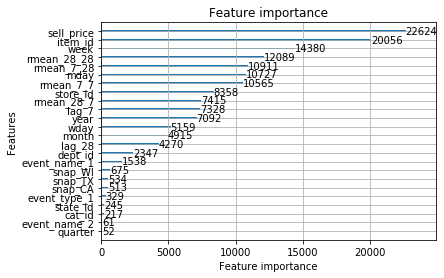

In [40]:
# Feature importance
lgb.plot_importance(lgb_model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='split', max_num_features=None, ignore_zero=True, figsize=None, dpi=None, grid=True, precision=3)

### Predict

In [41]:
y_pred = lgb_model.predict(test[train_cols])
test['sales'] = y_pred
test['id'] = test['id'].str.replace('_evaluation', '_validation')
test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,part,date,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
50735360,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1914,0.849116,test1,2016-04-25,...,8.382812,1.0,1.0,0.856934,1.142578,0.964355,1.036133,17,2,25
50735361,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1914,0.187804,test1,2016-04-25,...,3.970703,0.0,1.0,0.000000,0.714355,0.178589,0.357178,17,2,25
50735362,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,d_1914,0.602833,test1,2016-04-25,...,2.970703,1.0,0.0,1.286133,0.285645,0.464355,0.535645,17,2,25
50735363,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_1914,1.737387,test1,2016-04-25,...,4.640625,4.0,0.0,1.857422,3.000000,2.072266,1.892578,17,2,25
50735364,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_1914,0.968752,test1,2016-04-25,...,2.880859,0.0,1.0,0.856934,0.714355,1.071289,1.107422,17,2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51589075,FOODS_3_823_WI_3_validation,3044,6,9,2,2,d_1941,0.123848,test1,2016-05-22,...,2.980469,0.0,1.0,0.000000,0.285645,0.071411,0.214233,20,2,22
51589076,FOODS_3_824_WI_3_validation,3045,6,9,2,2,d_1941,0.119448,test1,2016-05-22,...,2.480469,0.0,0.0,0.000000,0.142822,0.035706,0.321533,20,2,22
51589077,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1941,0.244074,test1,2016-05-22,...,3.980469,0.0,0.0,0.000000,0.571289,0.142822,0.893066,20,2,22
51589078,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1941,0.247283,test1,2016-05-22,...,1.280273,0.0,3.0,0.000000,1.142578,0.285645,0.928711,20,2,22


### Submission

In [42]:
def predict(test, submission):
    predictions = test[['id', 'date', 'sales']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('lightGBM_submission.csv', index = False)

In [43]:
predict(test, submission)

**Predict with alphas**

In [44]:
alphas = [1.028, 1.023, 1.018]
y_pred_alphas = (sum(alphas)/len(alphas))*lgb_model.predict(test[train_cols])

In [45]:
test['sales'] = y_pred
test['id'] = test['id'].str.replace('_evaluation', '_validation')
test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,part,date,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
50735360,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1914,0.849116,test1,2016-04-25,...,8.382812,1.0,1.0,0.856934,1.142578,0.964355,1.036133,17,2,25
50735361,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_1914,0.187804,test1,2016-04-25,...,3.970703,0.0,1.0,0.000000,0.714355,0.178589,0.357178,17,2,25
50735362,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,d_1914,0.602833,test1,2016-04-25,...,2.970703,1.0,0.0,1.286133,0.285645,0.464355,0.535645,17,2,25
50735363,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_1914,1.737387,test1,2016-04-25,...,4.640625,4.0,0.0,1.857422,3.000000,2.072266,1.892578,17,2,25
50735364,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_1914,0.968752,test1,2016-04-25,...,2.880859,0.0,1.0,0.856934,0.714355,1.071289,1.107422,17,2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51589075,FOODS_3_823_WI_3_validation,3044,6,9,2,2,d_1941,0.123848,test1,2016-05-22,...,2.980469,0.0,1.0,0.000000,0.285645,0.071411,0.214233,20,2,22
51589076,FOODS_3_824_WI_3_validation,3045,6,9,2,2,d_1941,0.119448,test1,2016-05-22,...,2.480469,0.0,0.0,0.000000,0.142822,0.035706,0.321533,20,2,22
51589077,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1941,0.244074,test1,2016-05-22,...,3.980469,0.0,0.0,0.000000,0.571289,0.142822,0.893066,20,2,22
51589078,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1941,0.247283,test1,2016-05-22,...,1.280273,0.0,3.0,0.000000,1.142578,0.285645,0.928711,20,2,22


In [46]:
def predict(test, submission):
    predictions = test[['id', 'date', 'sales']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('lightGBM_withalphas_submission.csv', index = False)

In [47]:
predict(test, submission)